In [1]:
from collections import Counter
import matplotlib.pyplot as plt
from operator import itemgetter

from bin.alphafold_exploration.alphabets.dayhoff_recoding import dayhoff_6_recode
from bin.alphafold_exploration.data.load_fasta import load_fasta

In [2]:
k = 6

def load_counts_from_file(filename, cutoff=100):
    _kmer_counts = Counter()
    _aa_counts = Counter()
    for seq in load_fasta(filename):
        # Prefilter at least 100 residues
        if len(seq) > cutoff:
            _aa_counts += Counter(seq)
            n_kmers = len(seq) - k + 1
            for i in range(n_kmers):
                kmer = seq[i:i + k]
                _kmer_counts[kmer] += 1
    return _kmer_counts, _aa_counts



In [3]:
rat_kmer_counts_100, rat_aa_counts_100 = load_counts_from_file('../data/swissprot/rats.fasta')
sprot_kmer_counts_100, sprot_aa_counts_100 = load_counts_from_file('../data/sprot/uniprot_sprot.fasta')

In [4]:
def plot_most_freq_kmers(kmer_counts, n=20):
    most_freq_kmers, most_freq_counts = zip(*kmer_counts.most_common(n))
    plt.bar(most_freq_kmers, most_freq_counts)
    plt.title('Most frequent kmers')
    plt.xticks(rotation=90)
    plt.show()

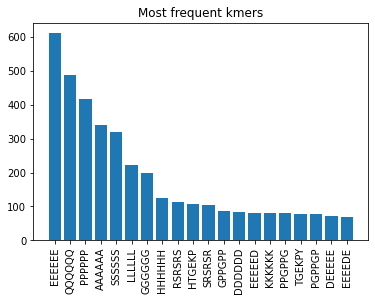

In [7]:
plot_most_freq_kmers(rat_kmer_counts_100)

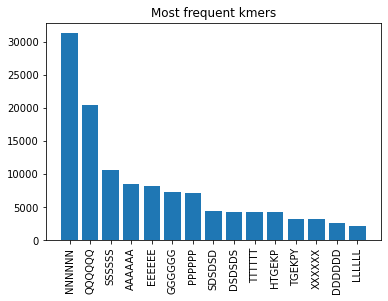

In [6]:
plot_most_freq_kmers(sprot_kmer_counts_100)

In [5]:
dayhoff_kmer_counts = Counter()

for seq in load_fasta('../data/sprot/uniprot_sprot.fasta'):
    dayhoff_seq = dayhoff_6_recode(seq)
    n_kmers = len(dayhoff_seq) - k + 1
    for i in range(n_kmers):
        kmer = dayhoff_seq[i:i + k]
        dayhoff_kmer_counts[kmer] += 1

In [6]:
total_aa = sum(aa_counts.values())
dayhoff_groups = {
    '0': ['A', 'S', 'T', 'G', 'P'],
    '1': ['D', 'N', 'E', 'Q'],
    '2': ['R', 'K', 'H'],
    '3': ['M', 'V', 'I', 'L'],
    '4': ['F', 'Y', 'W'],
    '5': ['C'],
    'X': ['X'],
    'U': ['U'],
    'Z': ['Z']
}
dayhoff_6_probabilities = {}
for g in dayhoff_groups:
    aa_counts_in_group = [aa_counts[aa] for aa in dayhoff_groups[g]]
    dayhoff_6_probabilities[g] = sum(aa_counts_in_group) / total_aa

In [7]:
dayhoff_6_probabilities

{'0': 0.32922909652059507,
 '1': 0.20074070895881038,
 '2': 0.13710666165861568,
 '3': 0.23194003570034052,
 '4': 0.07939838190735313,
 '5': 0.021565460172212076,
 'X': 1.2464198387851817e-05,
 'U': 6.232099193925909e-06,
 'Z': 9.587844913732167e-07}

In [8]:
normalized_dayhoff_kmer_counts = Counter()

for kmer in dayhoff_kmer_counts:
    counts = dayhoff_kmer_counts[kmer]
    for c in kmer:
        counts /= dayhoff_6_probabilities[c]
    normalized_dayhoff_kmer_counts[kmer] = counts

In [9]:
most_freq_dayhoff_kmers, most_freq_dayhoff_counts = zip(*dayhoff_kmer_counts.most_common(15))
most_freq_norm_dayhoff_kmers, most_freq_norm_dayhoff_counts = zip(*normalized_dayhoff_kmer_counts.most_common(15))

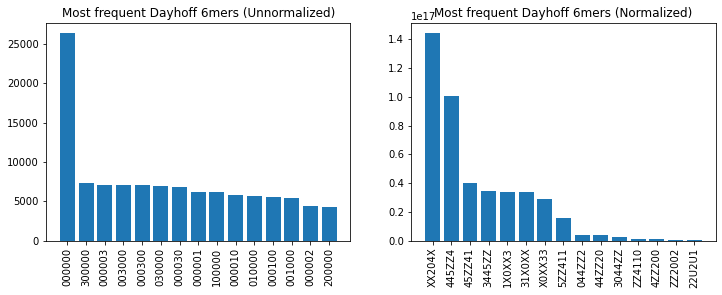

In [10]:
fig = plt.figure()
fig.set_figwidth(12)

plt.subplot(1, 2, 1)
plt.bar(most_freq_dayhoff_kmers, most_freq_dayhoff_counts)
plt.title('Most frequent Dayhoff 6mers (Unnormalized)')
plt.xticks(rotation=90)

plt.subplot(1, 2, 2)
plt.bar(most_freq_norm_dayhoff_kmers, most_freq_norm_dayhoff_counts)
plt.title('Most frequent Dayhoff 6mers (Normalized)')
plt.xticks(rotation=90)

plt.show()

**Problem 1**: How do we normalize by size of recoding class? For "000000" there are 5^6 possibilities vs just one for "555555".

- We could normalize by number of amino acids per group. However, this would ignore the fact that those are differently distributed.
- We could normalize by the sum of the probabilities of the amino acids per group. Much better but in order to not assume stationarity, we need to count the amino acids in the sequences we use.


**Problem 2**: What to do about X, U and Z?